In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [6]:
#I downloaded the data set from https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

df = pd.read_csv('amazon_reviews/Reviews.csv')

# for testing
df = df.head(500)

In [7]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### Some Data Analysis

Text(0, 0.5, 'Count')

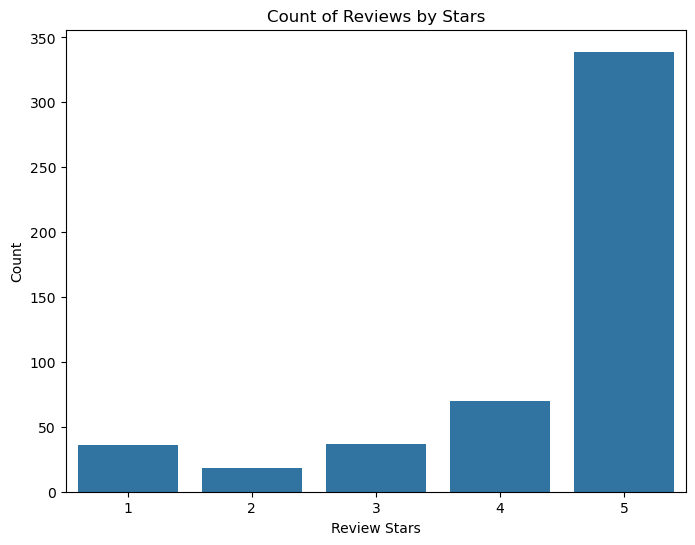

In [8]:
plt.figure(figsize=(8, 6))
sns.barplot(df.Score.value_counts().sort_index())
plt.title("Count of Reviews by Stars")
plt.xlabel("Review Stars")
plt.ylabel("Count")

## Using VADER sentiment scoring

In [9]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ankit/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
sia = SentimentIntensityAnalyzer()

In [11]:
# Running polarity score on the dataset

polarity_score = {}

for i, data in tqdm(df.iterrows(), total=len(df)):
    review_text = data['Text']
    review_id = data['Id']
    polarity_score[review_id] = sia.polarity_scores(review_text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [36]:
vaders_df = pd.DataFrame(polarity_score).T
vaders_df = vaders_df.reset_index().rename(columns={'index': 'Id'})

In [37]:
vaders_df = vaders_df.merge(df, on='Id')

<Axes: xlabel='Score', ylabel='compound'>

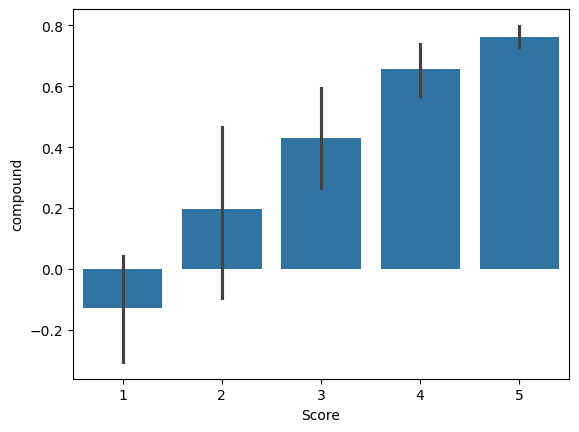

In [15]:
sns.barplot(vaders_df, x='Score', y='compound')

In [16]:
vaders_df.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

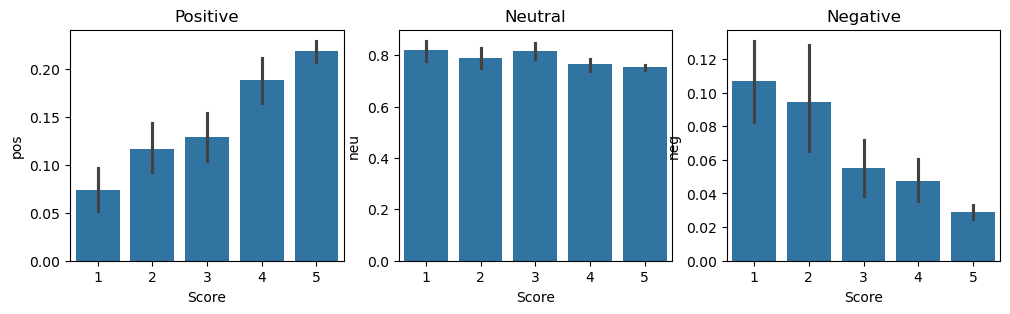

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=vaders_df, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders_df, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders_df, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout

## Using HuggingFace library

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [19]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def sentiment_score(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    
    return scores_dict


In [26]:
polarity_scores = {}
for i, data in tqdm(df.iterrows(), total=len(df)):
    try:
        review_text = data['Text']
        review_id = data['Id']
        vader_scores = sia.polarity_scores(review_text)
        roberta_scores = sentiment_score(review_text)
        
        #rename vader's key
        vader_scores_rename = {}
        for key,values in vader_scores.items():
            vader_scores_rename[f"vader_{key}"] = values
        
        polarity_scores[review_id] = {**vader_scores_rename, **roberta_scores}
    except RuntimeError:
        print("Skipping the error one.")

  0%|          | 0/500 [00:00<?, ?it/s]

Skipping the error one.
Skipping the error one.


In [28]:
sentiment_df = pd.DataFrame(polarity_scores).T
sentiment_df

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395
2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600
3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704
4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486
5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063
...,...,...,...,...,...,...,...
496,0.000,0.554,0.446,0.9725,0.001906,0.009862,0.988232
497,0.059,0.799,0.142,0.7833,0.004415,0.034215,0.961369
498,0.025,0.762,0.212,0.9848,0.006427,0.074537,0.919036
499,0.041,0.904,0.055,0.1280,0.865614,0.119366,0.015020


In [41]:
sentiment_df = sentiment_df.reset_index().rename(columns={'index':'Id'})

In [42]:
sentiment_df = sentiment_df.merge(df, on='Id')

In [50]:
sentiment_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,496,0.000,0.554,0.446,0.9725,0.001906,0.009862,0.988232,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
494,497,0.059,0.799,0.142,0.7833,0.004415,0.034215,0.961369,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
495,498,0.025,0.762,0.212,0.9848,0.006427,0.074537,0.919036,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
496,499,0.041,0.904,0.055,0.1280,0.865614,0.119366,0.015020,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


## Compare Scores between models

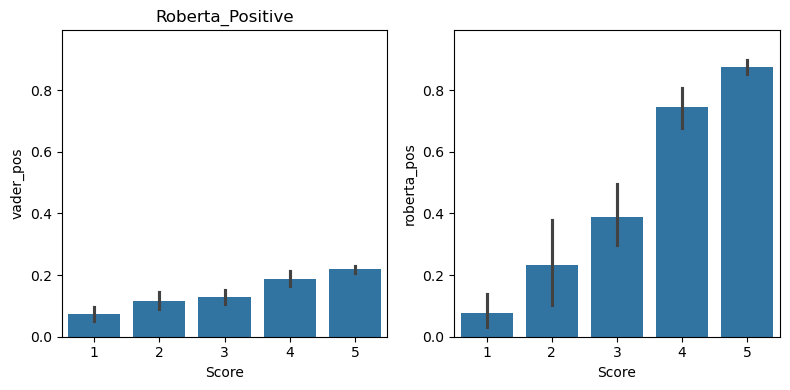

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.barplot(data=sentiment_df, x='Score', y='vader_pos', ax=axs[0])
sns.barplot(data=sentiment_df, x='Score', y='roberta_pos', ax=axs[1])
axs[0].set_title('Vader_Positive')
axs[0].set_title('Roberta_Positive')

max_y = max(sentiment_df['vader_pos'].max(), sentiment_df['roberta_pos'].max())
axs[0].set_ylim(0, max_y)
axs[1].set_ylim(0, max_y)

fig.tight_layout()

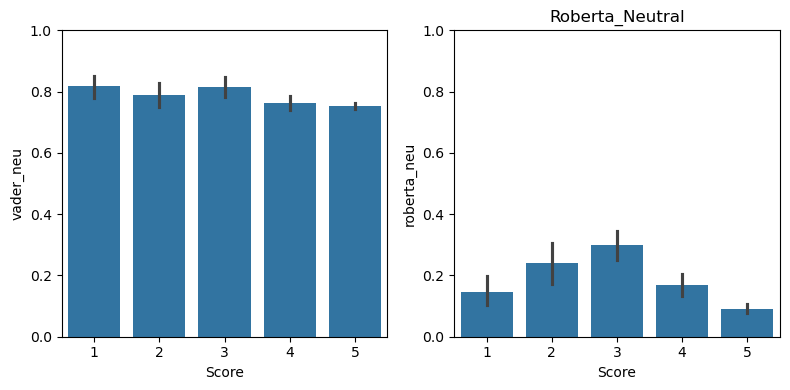

In [65]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.barplot(data=sentiment_df, x='Score', y='vader_neu', ax=axs[0])
sns.barplot(data=sentiment_df, x='Score', y='roberta_neu', ax=axs[1])
axs[1].set_title('Vader_Neutral')
axs[1].set_title('Roberta_Neutral')

max_y = max(sentiment_df['vader_neu'].max(), sentiment_df['roberta_neu'].max())
axs[0].set_ylim(0, max_y)
axs[1].set_ylim(0, max_y)

fig.tight_layout()

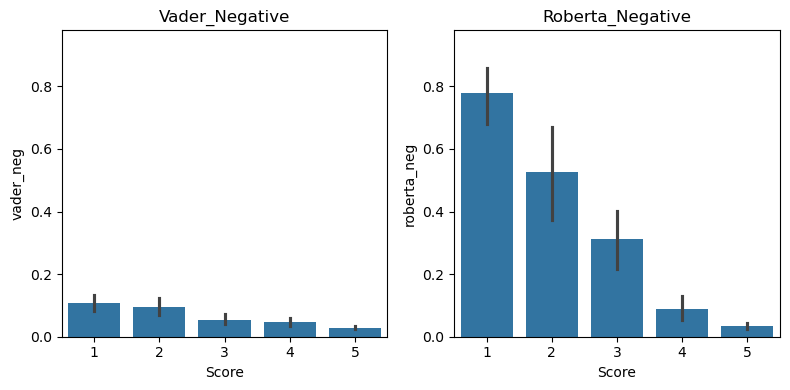

In [66]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.barplot(data=sentiment_df, x='Score', y='vader_neg', ax=axs[0])
sns.barplot(data=sentiment_df, x='Score', y='roberta_neg', ax=axs[1])
axs[0].set_title('Vader_Negative')
axs[1].set_title('Roberta_Negative')

max_y = max(sentiment_df['vader_neg'].max(), sentiment_df['roberta_neg'].max())
axs[0].set_ylim(0, max_y)
axs[1].set_ylim(0, max_y)

fig.tight_layout()